In [1]:
from math import sqrt
from numpy import concatenate
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error



data_set = pd.read_csv('/Users/shenghaoisyummy/Capstone/feature_extraction_data_dummis.csv', index_col=0)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
list(data_set)
data_set.head()
def time_to_total_minutes(df):
    df['target_minitues'] = df['arrv_late_time']/60

time_to_total_minutes(data_set)

In [3]:
data_Y = data_set[['target_minitues']]
data_set.drop(['actual_station_arrv_time_hours','actual_station_arrv_time_minutes', 'arrv_late_time', 'dprt_late_time', 'actual_station_dprt_time_hours', 'actual_station_dprt_time_minutes', 'target_minitues'], axis=1, inplace=True)


In [4]:
data_X = VarianceThreshold(threshold=3).fit_transform(data_set)

In [5]:
data_Y

,target_minitues
node_seq_order,
2,-1.0
3,-1.0
4,-1.0
5,-2.0
6,-1.0
7,-1.0
8,-1.0
9,-1.0
10,-1.0


In [6]:
# make sure value as float
data_X_values = data_X
data_X_values = data_X_values.astype('float32')

data_Y_values = data_Y.values
data_Y_values = data_Y_values.astype('float32')
# normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
data_X_values = scaler.fit_transform(data_X_values)
data_Y_values = scaler.fit_transform(data_Y_values)
# split train test
train_X, test_X, train_y, test_y = train_test_split(data_X_values, data_Y_values, test_size = 0.2, random_state = 4)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))



In [7]:
model = Sequential()

Train on 14362 samples, validate on 3591 samples
Epoch 1/15
 - 85s - loss: 0.0158 - val_loss: 0.0102
Epoch 2/15
 - 80s - loss: 0.0099 - val_loss: 0.0081
Epoch 3/15
 - 82s - loss: 0.0090 - val_loss: 0.0104
Epoch 4/15
 - 80s - loss: 0.0086 - val_loss: 0.0059
Epoch 5/15
 - 80s - loss: 0.0083 - val_loss: 0.0064
Epoch 6/15
 - 80s - loss: 0.0081 - val_loss: 0.0076
Epoch 7/15
 - 80s - loss: 0.0078 - val_loss: 0.0064
Epoch 8/15
 - 80s - loss: 0.0077 - val_loss: 0.0059
Epoch 9/15
 - 81s - loss: 0.0076 - val_loss: 0.0065
Epoch 10/15
 - 80s - loss: 0.0074 - val_loss: 0.0067
Epoch 11/15
 - 1857s - loss: 0.0074 - val_loss: 0.0058
Epoch 12/15
 - 83s - loss: 0.0073 - val_loss: 0.0057
Epoch 13/15
 - 80s - loss: 0.0072 - val_loss: 0.0057
Epoch 14/15
 - 84s - loss: 0.0072 - val_loss: 0.0057
Epoch 15/15
 - 88s - loss: 0.0071 - val_loss: 0.0058


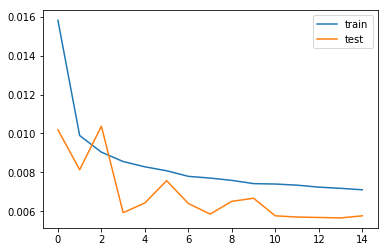

Test RMSE: 6.362


In [8]:
model.add(LSTM(70,  dropout=0, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='relu'))

model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=15, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)